<a href="https://colab.research.google.com/github/Ankur-v-2004/Industrial-data-science/blob/main/Titanic_(EDA%2CCleaning%2CFeatureEng%2CModeling%2Cetc).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'titanic:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F3136%2F26502%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240415%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240415T145343Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D5c89caf7f476f252dfa16df2511c05e0733f06336705c08313d0ec8f4195ca4d6268086a1117f0b87e35b1420a8aeb7b4b4df3518f3e27f9a7a45fed8141285f559ac0712489a1dcbc409abab7faf14373bcbc034a2de6b2db11668512758722f9e1cb7a16100ce67213d438c51793ca5eac9e74abbf9654476a9df259363609546e7693d034cff39b246b916cb91b2266dd48c65aed6f2af2fbec3f8684ef7a2128aa74d021f2a213ef8690f9bf6acf5cc1e1fc222a1bd42dc5f4612990c9cccfd4fb40f02a8a52bcf5503d888039ffadd5e02325759f4836f94910b0e3bb1dc20930e9e4e306a8f0a166c3eda337364d555c72c242ebd79bc9523b838c3ccf'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 34877 bytes downloaded
Downloaded and uncompressed: titanic
Data source import complete.


## **<div class="alert alert-block alert-info"> 1. Introduction <a class="anchor"  id="1"></a></div>**

* **Overview**

[Titanic Overview](https://www.kaggle.com/competitions/titanic/overview)

* **Dataset:**

[Titanic Dataset](https://www.kaggle.com/competitions/titanic/data)


## **<div class="alert alert-block alert-info"> 2. Import Data and Libraries <a class="anchor"  id="2"></a> </div>**

In [2]:


import numpy as np # linear algebra
from numpy import mean
from numpy import std
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_score, KFold
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score

import warnings
warnings.filterwarnings("ignore")


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/titanic/test.csv
/kaggle/input/titanic/train.csv
/kaggle/input/titanic/gender_submission.csv


In [3]:
# Load Train Dataset
df_train = pd.read_csv("/kaggle/input/titanic/train.csv")
print(type(df_train))

# Load Test Dataset
df_test = pd.read_csv("/kaggle/input/titanic/test.csv")
print(type(df_test))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


## **<div class="alert alert-block alert-info">3. Initial Data Inspection <a class="anchor"  id="3"></a></div>**
Basic commands to view the dataset structure, size, and a few samples.

In [4]:
# Display the first 5 rows of data

df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
# Display the Size of data

df_train_sh = df_train.shape
print(f'This train dataset contains {df_train_sh[0]} rows and {df_train_sh[1]} columns\n')

df_test_sh = df_test.shape
print(f'This train dataset contains {df_test_sh[0]} rows and {df_test_sh[1]} columns')

This train dataset contains 891 rows and 12 columns

This train dataset contains 418 rows and 11 columns


**The test_data has one column less than the train_data because the target column (<code>Survived</code>) is not present in it.**

In [6]:
# Check the data type of each column

print(df_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


## **<div class="alert alert-block alert-info">4. Data Cleaning and Preprocessing <a class="anchor"  id="4"></a></div>**


## **<div class="alert alert-block alert-info">4.1. Initial Exploratory Data Analysis (EDA) <a class="anchor"  id="4_1"></a></div>**

In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [8]:
df_train.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
PassengerId,891.0,446.00,257.35,1.00,223.50,446.00,668.5,891.00
Survived,891.0,0.38,0.49,0.00,0.00,0.00,1.0,1.00
Pclass,891.0,2.31,0.84,1.00,2.00,3.00,3.0,3.00
Age,714.0,29.70,14.53,0.42,20.12,28.00,38.0,80.00
SibSp,891.0,0.52,1.10,0.00,0.00,0.00,1.0,8.00
Parch,891.0,0.38,0.81,0.00,0.00,0.00,0.0,6.00
Fare,891.0,32.20,49.69,0.00,7.91,14.45,31.0,512.33


In [9]:
df_train[['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Survived']].corr()

,Pclass,Age,SibSp,Parch,Fare,Survived
Pclass,1.000000,-0.369226,0.083081,0.018443,-0.549500,-0.338481
Age,-0.369226,1.000000,-0.308247,-0.189119,0.096067,-0.077221
SibSp,0.083081,-0.308247,1.000000,0.414838,0.159651,-0.035322
Parch,0.018443,-0.189119,0.414838,1.000000,0.216225,0.081629
Fare,-0.549500,0.096067,0.159651,0.216225,1.000000,0.257307
Survived,-0.338481,-0.077221,-0.035322,0.081629,0.257307,1.000000


<Axes: >

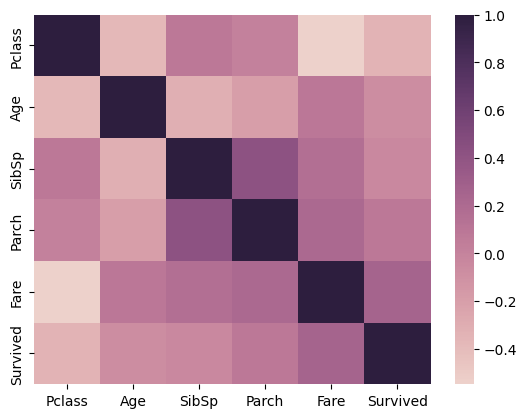

In [10]:
sns.heatmap(df_train[['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Survived']].corr(),
            cmap=sns.cubehelix_palette(as_cmap=True))

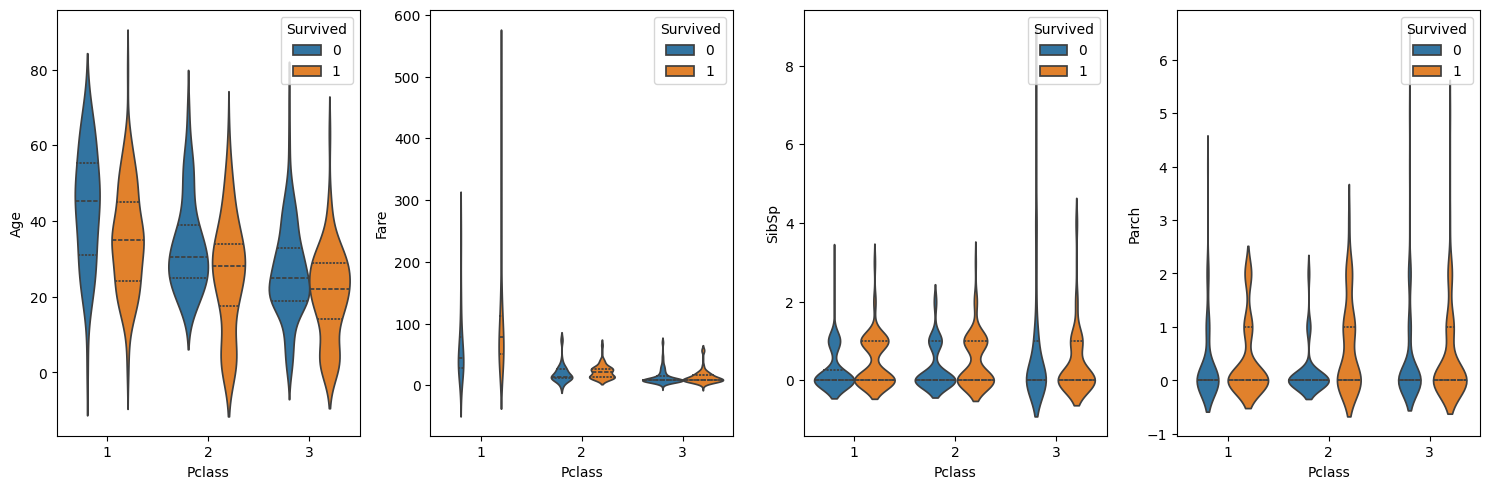

In [11]:
# Resize
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(15, 5))

sns.violinplot(data=df_train, x='Pclass', y='Age', hue='Survived', inner='quart', ax=axs[0])
sns.violinplot(data=df_train, x='Pclass', y='Fare', hue='Survived', inner='quart', ax=axs[1])
sns.violinplot(data=df_train, x='Pclass', y='SibSp', hue='Survived', inner='quart', ax=axs[2])
sns.violinplot(data=df_train, x='Pclass', y='Parch', hue='Survived', inner='quart', ax=axs[3])

# Adjust the distance between charts
plt.tight_layout()
plt.show()

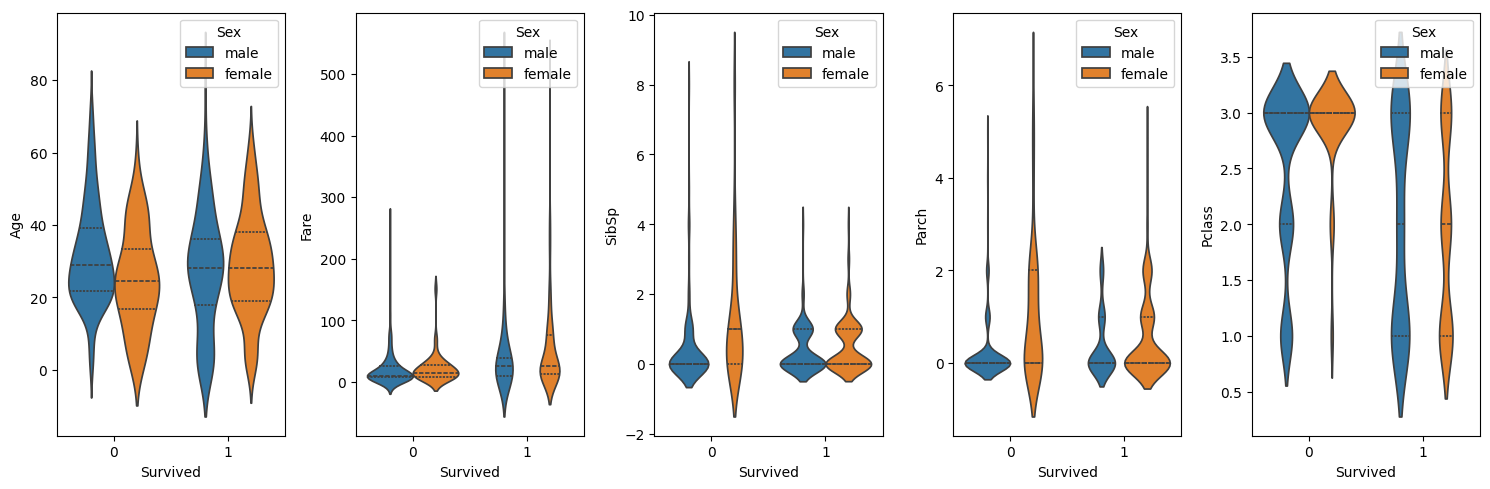

In [12]:
# Resize
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(15, 5))

sns.violinplot(data=df_train, x='Survived', y='Age', hue='Sex', inner='quart', ax=axs[0])
sns.violinplot(data=df_train, x='Survived', y='Fare', hue='Sex', inner='quart', ax=axs[1])
sns.violinplot(data=df_train, x='Survived', y='SibSp', hue='Sex', inner='quart', ax=axs[2])
sns.violinplot(data=df_train, x='Survived', y='Parch', hue='Sex', inner='quart', ax=axs[3])
sns.violinplot(data=df_train, x='Survived', y='Pclass', hue='Sex', inner='quart', ax=axs[4])

# Adjust the distance between charts
plt.tight_layout()
plt.show()

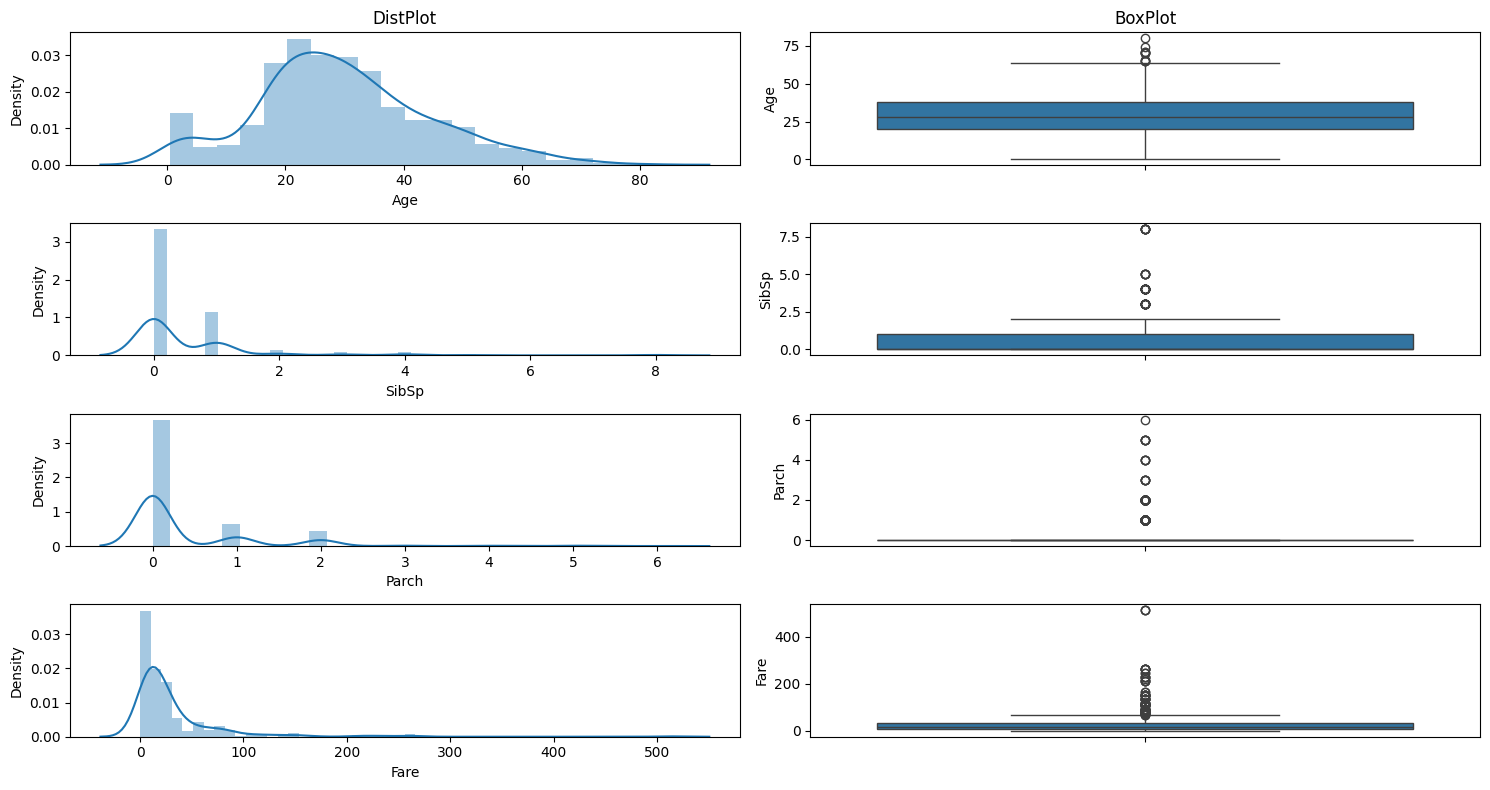

In [13]:
# Resize
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(15, 8))

# Age
sns.distplot(df_train['Age'], ax=axs[0, 0])
axs[0, 0].set_title("DistPlot")
sns.boxplot(df_train['Age'], ax=axs[0, 1])
axs[0, 1].set_title("BoxPlot")

# SibSp
sns.distplot(df_train['SibSp'], ax=axs[1, 0])
axs[0, 0].set_title("DistPlot")
sns.boxplot(df_train['SibSp'], ax=axs[1, 1])
axs[0, 1].set_title("BoxPlot")

# Parch
sns.distplot(df_train['Parch'], ax=axs[2, 0])
axs[0, 0].set_title("DistPlot")
sns.boxplot(df_train['Parch'], ax=axs[2, 1])
axs[0, 1].set_title("BoxPlot")

# Fare
sns.distplot(df_train['Fare'], ax=axs[3, 0])
axs[0, 0].set_title("DistPlot")
sns.boxplot(df_train['Fare'], ax=axs[3, 1])
axs[0, 1].set_title("BoxPlot")

# Adjust the distance between charts
plt.tight_layout()
plt.show()

## **<div class="alert alert-block alert-info">4.2. Handling Missing Values <a class="anchor"  id="4_2"></a></div>**

In [ ]:
# Selection of important variables for the model
df_train = df_train[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Survived']]

# Handling missing values
df_train.isnull().sum()

In [ ]:
df_train.isnull().mean()*100

**About 20% (177) of the <code>Age</code> column, 77% (687) of the <code>Cabin</code> column and 0.22% (2) of the <code>Embarked</code> column are missing data.**

In [ ]:
# Delete 2 rows of missing data in column Embarked

df_train.dropna(subset=['Embarked'], inplace=True)

**There are 177 missing data in the <code>Age</code> column, which is about <font color='red'>20%</font> of the total data
Removing the age column is a mistake; Deleting the missing 177 rows is also wrong.**

**So let's predict the missing data in the age column.**

**For this, I first consider the <code>Age</code> column as the target column and try to predict the missing values with the rest of the variables.**

## **<div class="alert alert-block alert-info">4.2.1. Encode Categorical Data<a class="anchor"  id="4_2_1"></a></div>**

#### **Dummy variable encoding**

**The one hot encoding creates one binary variable for each category. The problem is that this
representation includes redundancy. For example, if we know that [1, 0, 0] represents <font color='blue'>*blue*</font> and
[0, 1, 0] represents <font color='green'>*green*</font> we don’t need another binary variable to represent <font color='red'>*red*</font>, instead we
could use 0 values alone, e.g. [0, 0]. This is called a dummy variable encoding, and always
represents C categories with C − 1 binary variables.**

**Reference**. Jason Brownlee, [Data Preparation for Machine Learning](https://machinelearningmastery.com/data-preparation-for-machine-learning/), Page 245.

In [14]:
# Dummy variable encoding
df_train = pd.get_dummies(df_train, columns=['Embarked', ], drop_first=True)
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked_Q,Embarked_S
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,False,True
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,False,False
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,False,True
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,False,True
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,False,True


In [15]:
# Ordinal encode input variables
ordinal_e = OrdinalEncoder()
df_train[['Sex','Embarked_Q', 'Embarked_S']] = ordinal_e.fit_transform(df_train[['Sex','Embarked_Q', 'Embarked_S']])
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked_Q,Embarked_S
0,1,0,3,"Braund, Mr. Owen Harris",1.0,22.0,1,0,A/5 21171,7.2500,NaN,0.0,1.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0.0,38.0,1,0,PC 17599,71.2833,C85,0.0,0.0
2,3,1,3,"Heikkinen, Miss. Laina",0.0,26.0,0,0,STON/O2. 3101282,7.9250,NaN,0.0,1.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0.0,35.0,1,0,113803,53.1000,C123,0.0,1.0
4,5,0,3,"Allen, Mr. William Henry",1.0,35.0,0,0,373450,8.0500,NaN,0.0,1.0


## **<div class="alert alert-block alert-info">4.2.2. Data Imputation<a class="anchor"  id="4_2_2"></a></div>**

In [16]:
df_impu = df_train.copy()
df_impu.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked_Q,Embarked_S
0,1,0,3,"Braund, Mr. Owen Harris",1.0,22.0,1,0,A/5 21171,7.2500,NaN,0.0,1.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0.0,38.0,1,0,PC 17599,71.2833,C85,0.0,0.0
2,3,1,3,"Heikkinen, Miss. Laina",0.0,26.0,0,0,STON/O2. 3101282,7.9250,NaN,0.0,1.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0.0,35.0,1,0,113803,53.1000,C123,0.0,1.0
4,5,0,3,"Allen, Mr. William Henry",1.0,35.0,0,0,373450,8.0500,NaN,0.0,1.0


In [17]:
# Train, test sets
df_impu_train = df_impu[df_impu.Age.notnull()]
df_impu_test = df_impu[df_impu.Age.isnull()]

# Imputation train set
df_impu_train_X = df_impu_train.drop('Age', axis=1)
df_impu_train_y = df_impu_train['Age']

# Imputation test set
df_impu_test_X = df_impu_test.drop('Age', axis=1)

## **<div class="alert alert-block alert-info">4.3. Dealing with Outliers<a class="anchor"  id="4_3"></a></div>**

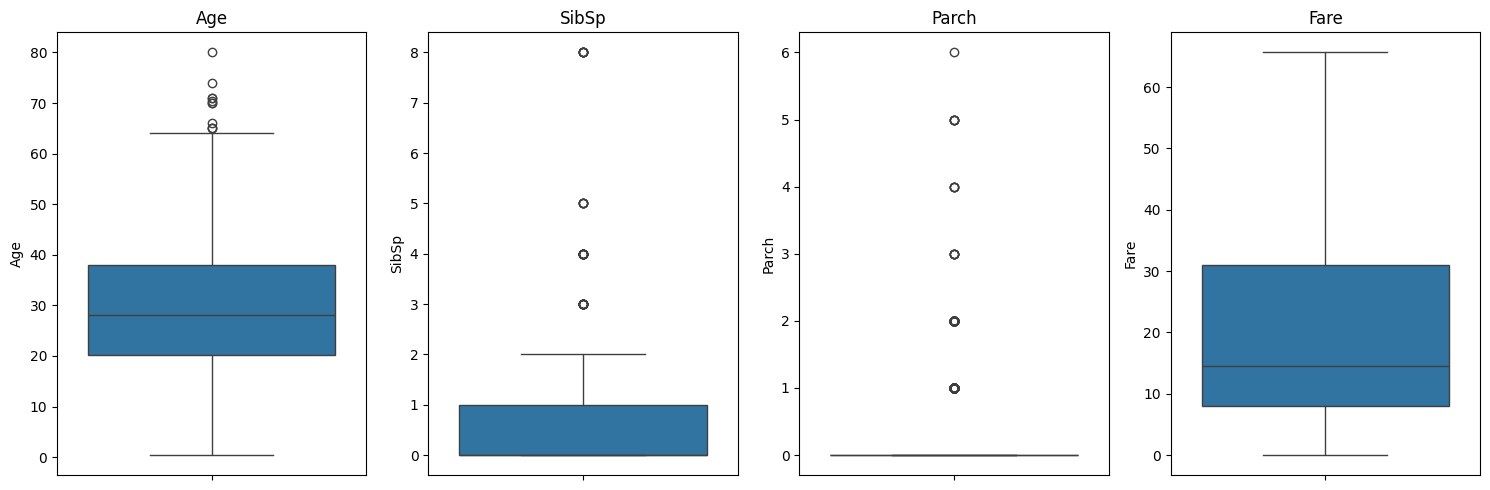

In [22]:

import matplotlib.pyplot as plt
# Outliers
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(15, 5))

sns.boxplot(df_train['Age'], ax=axs[0])
axs[0].set_title("Age")
sns.boxplot(df_train['SibSp'], ax=axs[1])
axs[1].set_title("SibSp")
sns.boxplot(df_train['Parch'], ax=axs[2])
axs[2].set_title("Parch")
sns.boxplot(df_train['Fare'], ax=axs[3])
axs[3].set_title("Fare")

# Adjust the distance between charts
plt.tight_layout()
plt.show()
